In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


Use the following function as your training data set,
\begin{align}
n(z)=\frac{n_0}{1+ exp(-z/\sigma)}
\end{align}

For the above formula , set $n_0$ as 10, $z\epsilon[-10,10]$, and $\sigma=2$ 

In [2]:
import tensorflow as tf
import numpy as np
from tensorflow.keras.layers import Input, Dense, Dropout
from tensorflow.keras import Sequential

## **Defining the functions for generating dataset**

In [18]:
def create_toy_regression_dataset(xmin=-10., xmax=10, noise_std=.2):
    x_trn = np.linspace(xmin, xmax, 1000, dtype=np.float32)
    y_trn = (10/(1 + np.exp(-1*x_trn)/2))+np.random.normal(0,noise_std,size = 1000).astype(np.float32)

    x_gt = np.linspace(xmin, xmax, 1000, dtype=np.float32)
    y_gt = 10/(1 + np.exp(-x_trn)/2)

    x_tst = np.linspace(xmin, xmax, 1000, dtype=np.float32)
    y_tst = (10/(1 + np.exp(-x_trn)/2))+np.random.normal(0, noise_std, size=1000).astype(np.float32)
    return x_gt, y_gt, x_trn, y_trn, x_tst, y_tst


## **Defining a function to plot the analytical graph about the regression task**


In [4]:
def plot_regression_model_analysis(gt=None,  trn=None, tst=None,
                                   pred=None, xlim=None, ylim=None,
                                   title=None):
    if gt:
        x_gt, y_gt = gt
        plt.plot(x_gt, y_gt, 
                 alpha=.8, lw=2, label="ground truth")
    if trn:
        x_trn, y_trn = trn
        plt.scatter(x_trn,  y_trn,
                    s=8, ec='black', lw=1, fc=None, alpha=1,
                    label='train samples')
    
    if tst:
        x_tst, y_tst = tst
        plt.scatter(x_tst, y_tst, s=5, alpha=.1, label='test samples')

    if pred:
        x_tst, yhat_mean, yhat_std = pred
        plt.scatter(x_tst, yhat_mean, s=5, alpha=1, label='preds')

    if xlim:
        plt.xlim(*xlim)
        
    if ylim:
        plt.ylim(*ylim)
    
    if title:
        plt.title(title)
        
    plt.xlabel('x')
    plt.ylabel('y')
    plt.legend(bbox_to_anchor=(1.35, 1.03), loc='upper right', fancybox=False, framealpha=1.0)


### Generating the dataset

In [42]:
data1 = create_toy_regression_dataset(-10,10, noise_std = 0.2)
data2 = create_toy_regression_dataset(-10,10, noise_std = 0.5)

x1_gt = data1[0]
y1_gt = data1[1]
x1_trn = data1[2]
y1_trn = data1[3]
x1_tst = data1[4]
y1_tst = data1[5]

x2_gt = data2[0]
y2_gt = data2[1]
x2_trn = data2[2]
y2_trn = data2[3]
x2_tst = data2[4]
y2_tst = data2[5]

In [6]:
def gaussian_nll(y_true, y_pred):
    """
    Gaussian negative log likelihood
    
    Note: to make training more stable, we optimize
    a modified loss by having our model predict log(sigma^2)
    rather than sigma^2. 
    """
    
    y_true = tf.reshape(y_true, [-1])
    mu = y_pred[:, 0]
    si = y_pred[:, 1]
    loss = (si + tf.square(y_true - mu)/tf.math.exp(si)) / 2.0
    return tf.reduce_mean(loss)

## **Defining Regression Model**

In [54]:
model = Sequential([
    Dense(10, activation="relu"),
    Dense(19, activation="relu"),
    Dropout(0.5),
    Dense(2, activation=None)
])
optimizer = tf.keras.optimizers.Adam(1e-3)
model.compile(optimizer = optimizer, loss = gaussian_nll)

In [55]:
model.fit(x1_trn[:, np.newaxis],
            y1_trn[:, np.newaxis],
            batch_size = 64, epochs = 250, verbose = 0)

In [56]:
def predict(model, x, samples=500):
    '''
    Args:
        model: The trained keras model
        x: the input tensor with shape [N, M]
        samples: the number of monte carlo samples to collect
    Returns:
        y_mean: The expected value of our prediction
        y_std: The standard deviation of our prediction
    '''
    mu_arr = []
    si_arr = []

    for t in range(samples):
        y_pred = model(x, training=True)
        mu = y_pred[:, 0]
        si = y_pred[:, 1]

        mu_arr.append(mu)
        si_arr.append(si)

    mu_arr = np.array(mu_arr)
    si_arr = np.array(si_arr)
    var_arr = np.exp(si_arr)

    y_mean = np.mean(mu_arr, axis=0)
    y_variance = np.mean(var_arr + mu_arr**2, axis=0) - y_mean**2
    y_std = np.sqrt(y_variance)
    return y_mean, y_std

In [57]:
yhat_mean, yhat_std = predict(model, x1_tst[:, np.newaxis], samples=5)

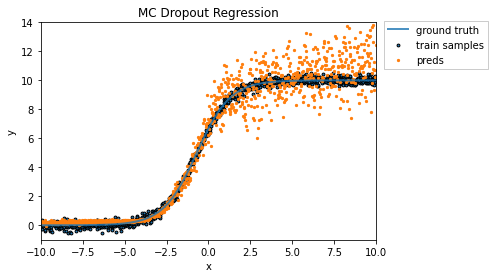

In [58]:
plot_regression_model_analysis(gt=(x1_gt, y1_gt),
                               trn=(x1_trn, y1_trn),
                               pred=(x1_tst, yhat_mean, yhat_std),
                               xlim=(-10, 10),
                               ylim=(-1, 14),
                               title='MC Dropout Regression')